In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K
from keras.applications import inception_v3, vgg16
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Convolution2D, Input, ZeroPadding2D, MaxPooling2D

Using TensorFlow backend.


In [2]:
input_shape = (224,224,3)
input_image = Input(shape=input_shape, name='input_image')
model = vgg16.VGG16(input_tensor=input_image, include_top=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
def total_variation_norm(x):
	x -= K.mean(x)

	a = K.square(x[:, 2:, :-2, :] - x[:, :-2, :-2, :])
	b = K.square(x[:, :-2, 2:, :] - x[:, :-2, :-2, :])

	tv = K.sum(K.pow(a + b, 1.25))

	return tv

def grads_wrt_input_to_excite_softmax(model, layer, neuron, l2=0.00000001, tv=0.0000001):
	input_tensor = model.input

	x = layer.output[:, neuron]

	objective = K.variable(0.)

	objective = objective + K.sum(K.square(x)) 

	# add continuity loss (gives image local coherence, can result in an artful blur)
	objective = objective - (tv * total_variation_norm(input_tensor))
	# add image L2 norm to loss (prevents pixels from taking very high values, makes image darker)
	objective = objective - (l2 * K.sum(K.square(input_tensor)))

	# compute the gradient of the input picture wrt this loss
	grads = K.gradients(objective, input_tensor)[0]

	# normalization trick: we normalize the gradient
	grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-6)

	# this function returns the loss and grads given the input picture
	iterate = K.function([input_tensor], [objective, grads])
	return iterate

def grads_wrt_input_to_excite_softmax_prelogit(model, layer_in, softmax_layer, neuron, l2=0.00000001, tv=0.0000001):
	input_tensor = model.input

	h = layer_in.output[0,:]
	h = K.expand_dims(h)
	w = softmax_layer.get_weights()
	z = K.dot(K.transpose(w[0]), h)
	x = z[neuron, :] + w[1][neuron]   
	objective = K.variable(0.)

	objective = objective + K.sum(K.square(x)) 

	# add continuity loss (gives image local coherence, can result in an artful blur)
	objective = objective - (tv * total_variation_norm(input_tensor))
	# add image L2 norm to loss (prevents pixels from taking very high values, makes image darker)
	objective = objective - (l2 * K.sum(K.square(input_tensor)))

	# compute the gradient of the input picture wrt this loss
	grads = K.gradients(objective, input_tensor)[0]

	# normalization trick: we normalize the gradient
	grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-6)

	# this function returns the loss and grads given the input picture
	iterate = K.function([input_tensor], [objective, grads])
	return iterate

def grads_wrt_input_for_softmax_neurons(model, layer_in, softmax_layer, neurons, l2=1e-6, tv=1e-5):
	input_tensor = model.input
	h = layer_in.output[0,:]
	h = K.expand_dims(h)
	w = softmax_layer.get_weights()
	z = K.dot(K.transpose(w[0]), h)
    
	objective = K.variable(0.)

	for n in neurons:
		x = z[n, :] + w[1][n]
		objective = objective + K.sum(K.square(x))

	# add continuity loss (gives image local coherence, can result in an artful blur)
	objective = objective - (tv * total_variation_norm(input_tensor))
	# add image L2 norm to loss (prevents pixels from taking very high values, makes image darker)
	objective = objective - (l2 * K.sum(K.square(input_tensor)))

	# compute the gradient of the input picture wrt this loss
	grads = K.gradients(objective, input_tensor)[0]

	# normalization trick: we normalize the gradient
	grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-6)

	# this function returns the loss and grads given the input picture
	iterate = K.function([input_tensor], [objective, grads])
	return iterate

def grads_for_channel(model, layer, channel=0):
	K.set_learning_phase(1)
	input_tensor = model.input
	x = layer.output[:,:,:,channel]
	
	w = x.shape[1]
	h = x.shape[2]
	shape = layer.output_shape

	objective = K.variable(0.)

	objective += K.sum(K.square(x[:, 2: w-2, 2:h-2])) / np.prod(shape[1:])

	# add continuity loss (gives image local coherence, can result in an artful blur)
	objective -= 0.0000005 * total_variation_norm(input_tensor) / np.prod(input_shape)
	# add image L2 norm to loss (prevents pixels from taking very high values, makes image darker)
	objective -= 0.0000001 * K.sum(K.square(input_tensor)) / np.prod(input_shape)
	
	# compute the gradient of the input picture wrt this loss
	grads = K.gradients(objective, input_tensor)[0]

	# normalization trick: we normalize the gradient
	grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-6)

	# this function returns the loss and grads given the input picture
	iterate = K.function([input_tensor], [objective, grads])
	return iterate

def deprocess_image(x, convert_bgr2rgb=True):
	# Util function to convert a tensor into a valid image.

	x = x.reshape((x.shape[1], x.shape[2], 3))
	
	x /= 2.
	x += 0.5
	x *= 255.
	x = np.clip(x, 0, 255).astype('uint8')
	
	if convert_bgr2rgb:
		x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
	
	return x



After iteration: 0 loss is: 2.94192
After iteration: 8 loss is: 20.5381
After iteration: 16 loss is: 39.0517
After iteration: 24 loss is: 55.0524
After iteration: 32 loss is: 70.1121
After iteration: 40 loss is: 81.2283
After iteration: 48 loss is: 92.0332


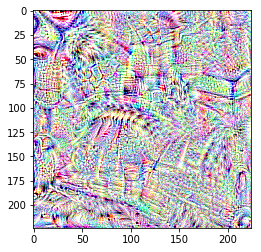

In [4]:
learning_rate = 0.05
iterations = 50
jitter = 0.8
layer_dict = dict([(layer.name, layer) for layer in model.layers])

iterate = grads_wrt_input_for_softmax_neurons(model, 
                                                    layer_dict["fc2"], 
                                                    layer_dict["predictions"], 
                                                    [924],
                                                    l2=1e-5,
                                                    tv=1e-6)
#iterate = grads_wrt_input_to_excite_softmax(model, layer_dict["predictions"], 462)
#iterate = grads_for_channel(model, layer_dict["block5_conv1"], 20)
input_img_data = np.random.random((1,)+input_shape)
for i in range(iterations):
    random_jitter = jitter * (np.random.random(input_shape) - 0.5)
    input_img_data += random_jitter
    loss_value, grads_value = iterate([input_img_data])
    input_img_data -= random_jitter

    input_img_data += learning_rate*grads_value
    if i % (iterations//6) == 0:
        print("After iteration:", i, "loss is:", loss_value)

img = deprocess_image(input_img_data)
plt.imshow(img)
